In [193]:
import pandas as pd
import numpy as np 
import matplotlib as plt

# models 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# model selection
from sklearn.model_selection import GridSearchCV

#metrics
from sklearn.metrics import precision_score, classification_report, confusion_matrix,f1_score
from sklearn.model_selection import RepeatedStratifiedKFold

#smote 
from imblearn.over_sampling import SMOTE

# data
from sklearn.model_selection import train_test_split

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Models
from sklearn.ensemble import GradientBoostingClassifier

# Data Import and Split 

In [210]:
# df_to_models_no_ohc = pd.read_csv(r'../data/to_models.csv', index_col=0)
df_to_models = pd.read_csv(r'../data/to_models.csv', index_col=0)
y = pd.read_csv(r'../data/y.csv', index_col=0)

In [195]:
# creating train/val and test dataframes 
X_train_val, X_test, y_train_val, y_test = train_test_split(df_to_models, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=15, 
                                                    shuffle=True, 
                                                    stratify=y
                                                   )

In [196]:
# from feature selection variables: 
feat_sel_var = ['ADR', 'BookingChanges', 'LeadTime', 'TotalOfSpecialRequests',
       'x0_Contract', 'x0_Transient', 'x0_Transient-Party', 'x1_No Deposit',
       'x1_Non Refund',
       'x5_big_company', 'x5_medium_company', 'x5_no_company',
       'x5_small_company', 'x6_avg_booker', 'x6_good_booker', 'x6_low_booker',
       'x6_no_booker', 'x6_super_booker', 'x7_Autumn', 'x7_Spring',
       'x7_Summer']

## Functions to Test Models 

In [197]:
def metrics(X_train, X_val, y_train, pred_train , y_val, pred_val, model):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print("Score: "+ str(model.score(X_train, y_train)))
    print("F1 Score: "+ str(f1_score(y_train, pred_train)))

    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    print("Score: "+ str(model.score(X_val, y_val)))
    print("F1 Score: "+ str(f1_score(y_val, pred_val)))

In [198]:
def avg_score(model, data_to_slice, y_to_slice, columns_to_use, smote = True, rsk_splits = 5, rspk_repeats = 5, feat_sel = False):
    # apply kfold
    skf = RepeatedStratifiedKFold(n_splits=rsk_splits, n_repeats=rspk_repeats)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    f1_list = []
    precision_list = []
    tn_avg = 0
    fp_avg = 0
    fn_avg = 0
    tp_avg = 0
    count = 0
    flag = 0 # feat sel flag to not keep printing 

    for train_index, test_index in skf.split(data_to_slice[columns_to_use],y_to_slice):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = data_to_slice[columns_to_use].iloc[train_index], data_to_slice[columns_to_use].iloc[test_index]
        y_train, y_val = y_to_slice.iloc[train_index], y.iloc[test_index]
        
        # SMOTE É AQUI 
        if smote: 
            smote = SMOTE(random_state = 11)
            X_train, y_train = smote.fit_resample(X_train, y_train)


        # applies the model 
        model_fit = model.fit(X_train, y_train)
        # predicts training 
        y_pred_train =  model_fit.predict(X_train)
        #predicts validation 
        y_pred_val = model_fit.predict(X_val)


        if feat_sel is True: 
            if hasattr(model_fit, 'feature_importances_'):
                feat_imp = pd.Series(model_fit.feature_importances_, columns_to_use).sort_values(ascending=False)
                feat_imp.plot(kind='bar', title='Feature Importances')

            elif flag == 0: 
                flag = 1
                print("This model has no feat_sel attb")
            else: 
                continue
        # prints metric results         
        #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)



        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
        count += 1
        tn_avg += tn
        fp_avg += fp
        fn_avg += fn
        tp_avg += tp

        
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        f1_score_val = f1_score(y_val, y_pred_val)
        prec_score = precision_score(y_val, y_pred_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        f1_list.append(f1_score_val)
        precision_list.append(prec_score)
        
  
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_f1 = round(np.mean(f1_list),3)
    std_f1 = round(np.std(f1_list),2)
    avg_precision = round(np.mean(precision_list),3)
    std_precision = round(np.std(precision_list),2)

    tn_avg = tn_avg / count
    fp_avg = fp_avg / count
    fn_avg = fn_avg / count
    tp_avg = tp_avg / count
    #print(confusion_matrix(y_val, y_pred_val))
    confmatrix = str(tp_avg)+ ' , ' + str(tn_avg) + ' \n ' + str(fp_avg) + ' , ' +  str(fn_avg)
    return str(avg_train) + '+/-' + str(std_train),\
            str(avg_test) + '+/-' + str(std_test) , str(avg_f1) + '+/-' + str(std_f1), str(avg_precision), confmatrix

## Decision Tree

In [200]:
dt_gini = DecisionTreeClassifier(criterion='gini')
dt_entropy = DecisionTreeClassifier(criterion='entropy')

### Split Criteria

In [202]:
avg_score(dt_gini, X_train_val, y_train_val, X_train_val.columns,True,2,2)

('0.997+/-0.0',
 '0.543+/-0.0',
 '0.35+/-0.0',
 '0.377',
 '2609.25 , 8932.0 \n 4316.0 , 5386.75')

In [203]:
avg_score(dt_entropy, X_train_val, y_train_val, X_train_val.columns,True,2,2)

('0.997+/-0.0',
 '0.544+/-0.0',
 '0.348+/-0.0',
 '0.377',
 '2586.5 , 8970.0 \n 4278.0 , 5409.5')

Entropy looks like the best choice although both criterias are very similar. 

### GridSearch

In [206]:
# tree params
param_grid = {
    'splitter': ['best', 'random'],
    'max_depth':range(5,16,2),
    'min_samples_split':range(200,1001,200),
    'min_samples_leaf': range(80,200,30),
    'min_impurity_decrease' : [0.01,0.03,0.05]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dt_entropy, param_grid = param_grid, scoring = 'precision')

grid_search.fit(X_train_val, y_train_val)
grid_search.best_params_, grid_search.best_score_

({'max_depth': 5,
  'min_impurity_decrease': 0.03,
  'min_samples_leaf': 80,
  'min_samples_split': 600,
  'splitter': 'random'},
 0.9729747814613937)

In [207]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=5, min_impurity_decrease=0.03, min_samples_leaf=80, min_samples_split=600, splitter='random')

In [209]:
avg_score(dt_model, X_train_val, y_train_val, X_train_val.columns,5,5)

('0.644+/-0.01',
 '0.509+/-0.04',
 '0.4+/-0.07',
 '0.376',
 '1467.0 , 2861.36 \n 2437.84 , 1731.4')

## Gradient Boost 

In [186]:
from sklearn.ensemble import GradientBoostingClassifier

In [187]:
gbm0 = GradientBoostingClassifier(random_state=10)

#### Small FeatSel for this specific model 

('0.813+/-0.0',
 '0.549+/-0.0',
 '0.343+/-0.0',
 '0.379',
 '2504.0 , 9149.0 \n 4099.0 , 5492.0')

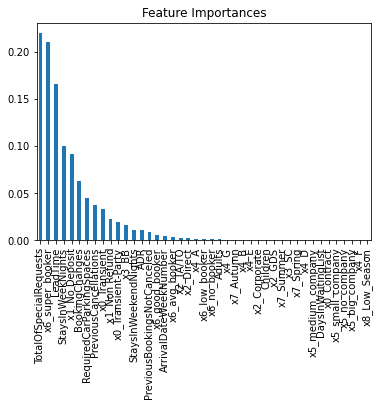

In [190]:
#Choose all predictors except target & IDcols
avg_score(gbm0, X_train_val, y_train_val, X_train_val.columns,True,2,2, True)

#### GridSearch Exploring 

In [67]:
gb_feats = ['TotalOfSpecialRequests', 'x6_super_booker', 'LeadTime',
             'PreviousCancellations', 'x1_Non Refund', 'x1_No Deposit',
             'x0_Transient','RequiredCarParkingSpaces','ADR','BookingChanges']

In [63]:
# tree param - min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_depth, max_leaf_nodes, max_features
# boost param - learning_rate, n_estimators, subsample


In [189]:
# tree params
gbm1 = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)
param_grid = {
    'n_estimators':range(20,81,10)
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm1, param_grid = param_grid, scoring = 'precision')

grid_search.fit(X_train_val[feat_sel_var], y_train_val)
grid_search.best_params_, grid_search.best_score_

({'n_estimators': 20}, 0.7344191244300585)

In [161]:
gbm2 = GradientBoostingClassifier(random_state=10, learning_rate=0.1, max_features='sqrt',n_estimators=20)
# tree params
param_grid = {
    'max_depth':range(5,16,2),
    'min_samples_split':range(200,1001,200)
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm0, param_grid = param_grid, scoring = 'precision')

grid_search.fit(X_train_val[feat_sel_var], y_train_val)
grid_search.best_params_, grid_search.best_score_

({'max_depth': 5, 'min_samples_split': 200}, 0.7236138218038821)

In [162]:
gbm3 = GradientBoostingClassifier(random_state=10, learning_rate=0.1, max_features='sqrt',n_estimators=20, max_depth=5, min_samples_split=600)
# tree params
param_grid = {
    'min_samples_leaf':range(30,71,10)
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm0, param_grid = param_grid, scoring = 'precision')

grid_search.fit(X_train_val[feat_sel_var], y_train_val)
grid_search.best_params_, grid_search.best_score_

({'min_samples_leaf': 70}, 0.7164060527385855)

#### Final Algorithm

In [ ]:
gbm4 = GradientBoostingClassifier(random_state=10, learning_rate=0.1, max_features='sqrt',n_estimators=20, max_depth=5, min_samples_split=600, min_samples_leaf=30)

('0.72+/-0.0',
 '0.52+/-0.01',
 '0.396+/-0.01',
 '0.376',
 '3339.6 , 7710.1 \n 5537.9 , 4656.4')

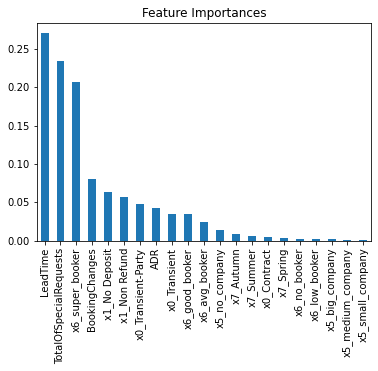

In [159]:
avg_score(gbm4, X_train_val, y_train_val, feat_sel_var,2,2,feat_sel=True)

The gradient boost has very low capabilities of predicting the cancellation aspect. 